In [20]:
%matplotlib widget
import os
import time
from collections import Counter
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
from rust_ephem import (
    EarthLimbConstraint,
    MoonConstraint,
    SunConstraint,
)
from tqdm.notebook import tqdm

from conops.battery import Battery
from conops.common import ACSMode, unixtime2date
from conops.config import Config
from conops.constraint import Constraint
from conops.ephemeris import compute_tle_ephemeris
from conops.groundstation import GroundStationRegistry
from conops.instrument import Instrument, InstrumentSet
from conops.pointing import Pointing
from conops.queue_ditl import QueueDITL
from conops.queue_scheduler import Queue
from conops.solar_panel import SolarPanel, SolarPanelSet
from conops.spacecraft_bus import AttitudeControlSystem, PowerDraw, SpacecraftBus

# Make sure we are working in UTC times,
os.environ["TZ"] = "UTC"
time.tzset()

## DITL Configuration

### Read in TLE


In [21]:
tle_file = "example.tle"

### Set time period to run DITL over

In this example, we'll start 2 days after the epoch of the TLE, at 00:00UT

In [22]:
length = 1
offset = 2
begin = datetime(2025, 11, 1)
end = begin + timedelta(days=1)

### Generate an Ephemeris for the time period

Using the TLE and the time period defined above, we generate an ephemeris for the spacecraft. This ephemeris will contain the position and velocity of the spacecraft for the entire simulation period, which is essential for determining what the spacecraft can see and when.


In [23]:
eph = compute_tle_ephemeris(
    begin=begin,
    end=end,
    tle="example.tle",
    step_size=60,
)

### Configure the SpaceCraft Model for the DITL

#### Configure the Spacacraft Bus

The next cell configures the spacecraft bus, which includes defining its power draw in different modes and the parameters for the attitude control system (ACS), such as slew rates and settle times.


In [24]:
# Configure the power draw for the spacecraft bus in various
# In this case, the spacecraft bus draws 70W in science mode, 100W while
# slewing, and has a nominal power draw of 50W in all other ACS modes.
power_draw = PowerDraw(
    nominal_power=50,
    power_mode={ACSMode.SCIENCE: 70, ACSMode.SLEWING: 100},
)

# Define the parameters for the attitude control system, currently this is
# defining the slew rate and acceleration limits, as well as the settle time after
# a slew.
acs = AttitudeControlSystem(
    settle_time=10,  # Units of seconds
    max_slew_rate=1,  # Units of deg/s
    slew_acceleration=0.01,  # Units of deg/s^2
)


# Configure the spacecraft bus with the power draw and ACS defined above.
spacecraft_bus = SpacecraftBus(
    name="Example Spacecraft Bus", power_draw=power_draw, attitude_control=acs
)

#### Slew time sanity check

The follow plot shows the calculated slew time as a function of slew degrees,
this acts as a good sanity check against putting in bad numbers that can break
the simulation.

Text(0.5, 1.0, 'Slew Time vs. Slew Angle')

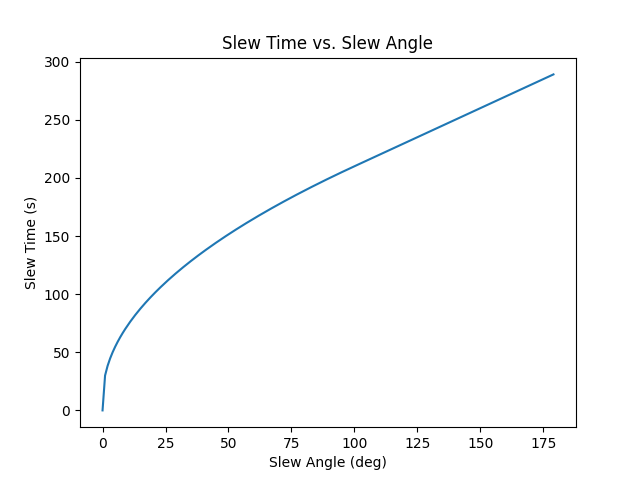

In [25]:
times = np.arange(0, 180)
plt.figure()
plt.plot(times, [acs.slew_time(t) for t in times])
plt.xlabel("Slew Angle (deg)")
plt.ylabel("Slew Time (s)")
plt.title("Slew Time vs. Slew Angle")

#### Configure the Instruments

Configure the instruments. Note a spacecraft can have multiple instruments, so
the `InstrumentSet` class holds all the instruments onboard. Right now a
Instrument is just a thing that draws power. The `PowerDraw` class defines how
much power the instrument draws in various ACS modes.


In [26]:
instrument_power = PowerDraw(
    nominal_power=50,
    power_mode={ACSMode.SCIENCE: 200, ACSMode.SLEWING: 50, ACSMode.SAA: 50},
)
optical_instrument = Instrument(
    name="Optical Imager",
    power_draw=instrument_power,
)

instrument_set = InstrumentSet(instruments=[optical_instrument])

#### Configure the Battery

Define the capacity and maximum allowed depth of discharge in nominal operations.


In [27]:
battery = Battery(watthour=1000, max_depth_of_discharge=0.5)

#### Configure the Solar Panel

Define the physical configuration of the solar panel, the max power generation
and the conversion efficiency.


In [28]:
# Configure each solar panel on the spacecraft, in this case we only have one
# fixed side mounted panel.
solar_panel = SolarPanel(
    name="Example Solar Panel",
    gimbled=False,  # not gimbled, if gimbled then would track sun
    sidemount=True,  # panel mounted on side of spacecraft, as opposed to pointing opposite of pointing direction
    max_power=474.21,  # Max power generation in Watts
    conversion_efficiency=0.94,  # Efficiency of solar panel
)
# Create a solar panel set to hold all the panels on the spacecraft
solar_panel_set = SolarPanelSet(panels=[solar_panel])

#### Configure the observing constraints

Observing constraints are defined using `rust-ephem` module's constraints,
basic observing constraints are Sun, Moona and Earth Limb avoidance. CONOPS
simulator has a built in Solar Panel Constraint that allows for the minimum
incidence angle of the Sun on the solar panel to be a constraint, not that
during spacecraft eclipse, this angle is not enforced.

Note here that the solar panel constraint is set up so that the Sun has to
be within 45 degrees of the solar panel. This is defined using a SunConstraint
where targets < 45 degrees from the Sun and < 45 degrees from the anti-Sun are
not available.


In [29]:
# We define here the maximum solar panel angle for the solar panel constraint
max_solar_panel_angle = 45  # degrees


constraint = Constraint(
    ephem=eph,
    sun_constraint=SunConstraint(min_angle=90),  # & ~EclipseConstraint(),
    moon_constraint=MoonConstraint(min_angle=20),
    earth_constraint=EarthLimbConstraint(min_angle=20),
    panel_constraint=SunConstraint(
        min_angle=max_solar_panel_angle, max_angle=180 - max_solar_panel_angle
    ),
)

#### Ground Station Configuration

We can define the locations of ground stations, and their capabilities. Here I
made up some ground stations for the sims. Note that each ground station comes
with a `schedule_probability` parameter. This is in order to simulate network
congestion, and to randomize the DITL. Essentially every time the groundstation
is in view, we roll a dice to determine if this one is scheduled. Schedule
probability = 1 means every time.

In [30]:
from conops.groundstation import Antenna, GroundStation

# Define a custom set of ground stations
# This is an example, you can add or remove stations as needed.
# The default ground stations are used in this example.

nairobi = GroundStation(
    code="NBO",
    name="Nairobi",
    latitude_deg=-1.2921,
    longitude_deg=36.8219,
    elevation_m=0.0,
    min_elevation_deg=10.0,
    antenna=Antenna(bands=["S"]),
    schedule_probability=0.7,
)

south_pole = GroundStation(
    code="SPO",
    name="South Pole",
    latitude_deg=-90.0,
    longitude_deg=0.0,
    elevation_m=2835.0,
    min_elevation_deg=10.0,
    antenna=Antenna(bands=["S"]),
    schedule_probability=0.2,
)

north_pole = GroundStation(
    code="NPO",
    name="North Pole",
    latitude_deg=90.0,
    longitude_deg=0.0,
    elevation_m=0.0,
    min_elevation_deg=10.0,
    antenna=Antenna(bands=["S"]),
    schedule_probability=0.2,
)

punta_veija = GroundStation(
    code="PVG",
    name="Punta Veija",
    latitude_deg=8.7832,
    longitude_deg=-71.2325,
    elevation_m=0.0,
    min_elevation_deg=10.0,
    antenna=Antenna(bands=["S"]),
    schedule_probability=0.5,
)


# Create a GroundStationRegistry with the custom stations
ground_station_registry = GroundStationRegistry(
    stations=[nairobi, south_pole, north_pole, punta_veija]
)

#### Create the configuration object

This configuration object holds all the spacecraft subsystems and constraints.
It is a Pydantic model, so this can be easily serialized to JSON so the
configuration can be saved.


In [31]:
# Create the configuration object
config = Config(
    name="Example Spacecraft Configuration",
    spacecraft_bus=spacecraft_bus,
    solar_panel=solar_panel_set,
    instruments=instrument_set,
    battery=battery,
    constraint=constraint,
    ground_stations=ground_station_registry,
)

#### Save the configuration 

Configuration can be saved to JSON for writing to disk. This way configuration
steps above can be done only once, and the JSON file can be part of a fixed,
version controlled spacecraft configuration.

In [32]:
# Serialize to JSON and save to disk
json = config.model_dump_json(indent=4)
with open("example_config.json", "w") as json_out:
    json_out.write(json)

# Read JSON from disk
with open("example_config.json", "r") as json_in:
    json = json_in.read()

# Deserialize from JSON
config = config.model_validate_json(json)

# Note that the ephemeris is not serialized, so we need to set it again
config.constraint.ephem = eph

### Ingest Targets for the DITL simulation

In this step we ingest targets into our simulation. This could be a list of
real science targets, an astronomical catalogue. For this simple example, we'll
just generate a list of random points on the sky.


In [33]:
number_of_targets = 1000
target_ra, target_dec = (
    np.random.uniform(0, 360, number_of_targets),
    np.random.uniform(-90, 90, number_of_targets),
)
print(f"Number of pointings = {len(target_ra)}")

Number of pointings = 1000


#### Populate Target Queue

Take the list of targets, and use them to populate the Target `Queue`. This also
pre-calculates the visibility windows for each target. 

In [34]:
targids = list(range(10000, 10000 + len(target_ra)))

targlist = Queue()
targlist.ephem = eph
for i in tqdm(range(len(targids))):
    pointing = Pointing(
        constraint=config.constraint, acs_config=config.spacecraft_bus.attitude_control
    )
    pointing.merit = 40
    pointing.ra = target_ra[i]
    pointing.dec = target_dec[i]
    pointing.obsid = targids[i]
    pointing.name = f"pointing_{pointing.obsid}"
    pointing.exptime = 5000
    pointing.visibility()
    targlist.append(pointing)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Set up the Queue Scheduled DITL


In [35]:
# %%prun
ditls = list()
for i in range(1):
    targlist.reset()
    ditl = QueueDITL(config=config)
    ditl.acs.last_slew = None
    ditl.queue = targlist
    ditl.ephem = eph
    ditl.begin = begin
    ditl.end = end
    ditl.calc()
    ditls.append(ditl)

Scheduling groundstation passes...
Scheduled pass: 2025-305-03:30:00   SPO   8.0 mins
Scheduled pass: 2025-305-09:08:00   NPO   8.0 mins
Scheduled pass: 2025-305-13:09:00   SPO   8.0 mins
Scheduled pass: 2025-305-15:34:00   NPO   8.0 mins
Scheduled pass: 2025-305-19:59:00   NBO   8.0 mins
2025-305-00:00:00, RA: 16.02786745162226, Dec: 13.811909277581307, Mode: SCIENCE
2025-305-00:00:00 Fetching new PPT from Queue (last RA/Dec 0.00/0.00)
2025-305-00:00:00 Searching 78 targets in queue...
2025-305-00:00:00 Fetched PPT: 2025-305-00:00:00 pointing_10661 (10661) RA=97.7600, Dec=-35.131414, Roll=-1.0, Merit=100.99199982145404
2025-305-00:00:00: Enqueued SLEW_TO_TARGET command for execution  (queue size: 1)
2025-305-00:01:00: Executing SLEW_TO_TARGET command.
2025-305-00:01:00: Started slew to RA=97.75999442245445 Dec=-35.13141429553969
2025-305-00:01:00, RA: 30.53360254333542, Dec: 2.916456518591326, Mode: SLEWING
2025-305-00:02:00, RA: 70.80000677752514, Dec: -25.073299600583624, Mode: SLEW

#### Check to see if any Battery charging events happened

In [36]:
# Check for emergency charging behavior
charging_cmds = [
    cmd
    for cmd in ditl.acs.executed_commands
    if "BATTERY_CHARGE" in cmd.command_type.name
]
print(f"Total battery charge commands: {len(charging_cmds)}")
for i, cmd in enumerate(charging_cmds[:20]):  # Show first 20
    print(f"{i}: {unixtime2date(cmd.execution_time)}: {cmd.command_type.name}")

# Check for CHG slews
# chg_slews = [s for s in ditl.acs.slew_history if hasattr(s, 'obstype') and s.obstype == 'CHG']
# print(f"\nTotal CHG slews: {len(chg_slews)}")
# for i, slew in enumerate(chg_slews[:10]):
#    print(f"{i}: RA={slew.endra:.1f} Dec={slew.enddec:.1f} obsid={slew.obsid}")

Total battery charge commands: 0


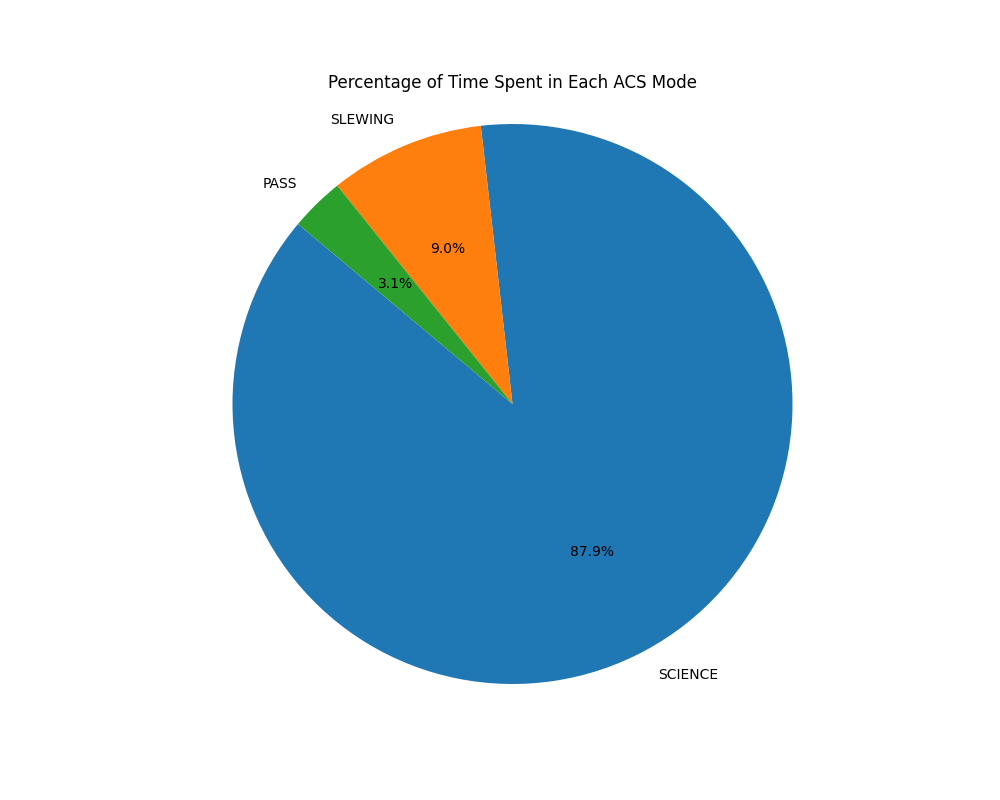

In [37]:
# Convert your data
times = [unixtime2date(t) for t in ditl.utime]
modes = [m.name for m in ditl.mode]
battery_levels = ditl.batterylevel  # unused in this example, but you can use later

# Count occurrences of each mode
mode_counts = Counter(modes)

# Prepare data for pie chart
labels = list(mode_counts.keys())
sizes = list(mode_counts.values())

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Percentage of Time Spent in Each ACS Mode")
plt.axis("equal")  # Equal aspect ratio ensures pie is a circle
plt.show()

#### Plot the output of the DITL simulation

This plot shows spacecraft RA/Dec over time, ACS mode, Battery Charge, Solar
Panel illumination, power level and observation ID

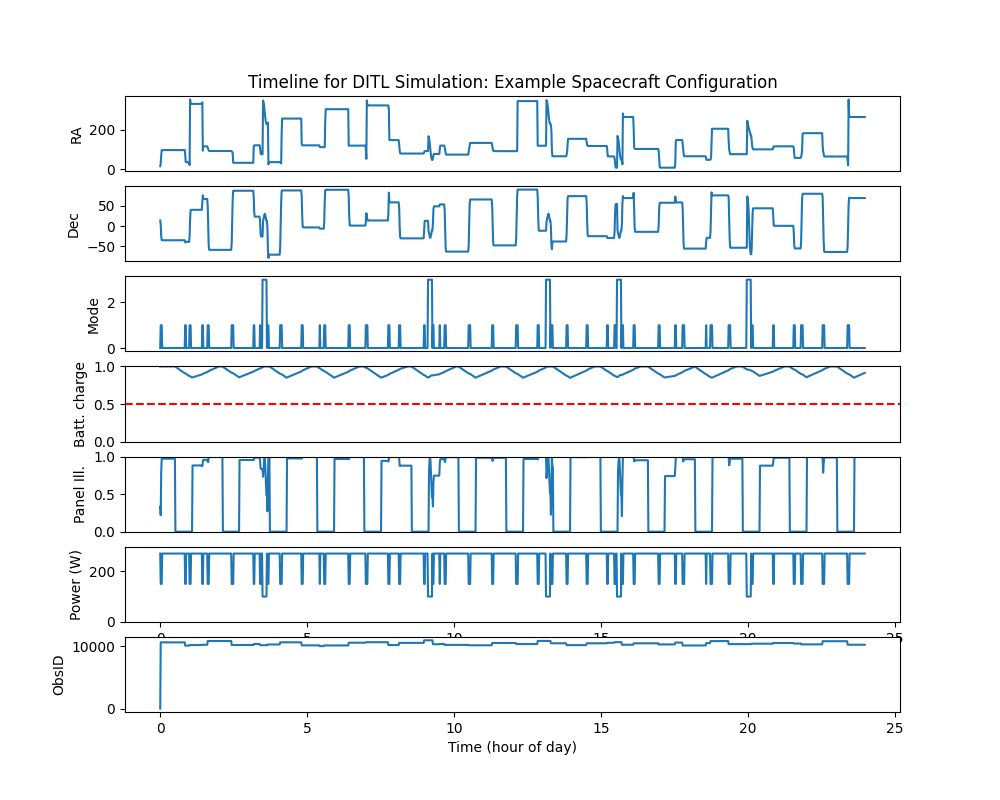

In [38]:
# Plot DITL results
ditl.plot()

#### Plot a Histogram showing Observing Efficiency

This histogram plots the time in differing ACS modes, from which we can judge
the overall uptime for 

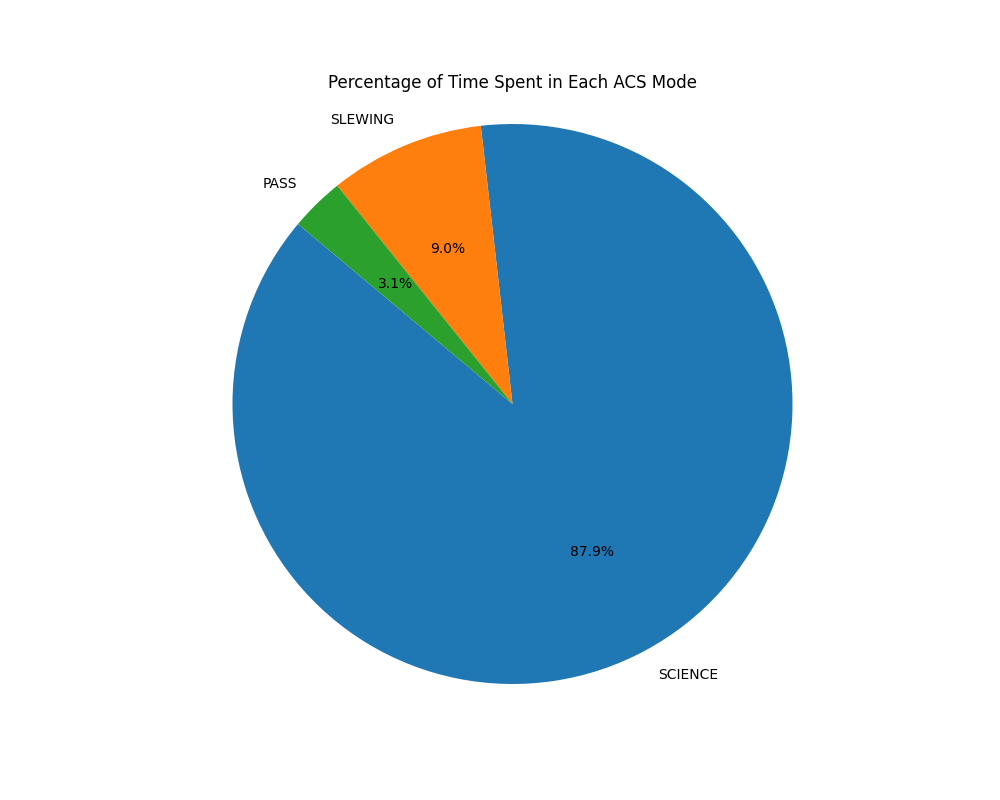

In [39]:
# Convert your data
times = [unixtime2date(t) for t in ditl.utime]
modes = [m.name for m in ditl.mode]
battery_levels = ditl.batterylevel  # unused in this example, but you can use later

# Count occurrences of each mode
mode_counts = Counter(modes)

# Prepare data for pie chart
labels = list(mode_counts.keys())
sizes = list(mode_counts.values())

# Create pie chart
plt.figure(figsize=(10, 8))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Percentage of Time Spent in Each ACS Mode")
plt.axis("equal")  # Equal aspect ratio ensures pie is a circle
plt.show()

In [40]:
f"Mean power generated: {np.mean(ditl.panel_power):.2f}W"

'Mean power generated: 269.50W'

In [41]:
f"Power generation efficiency = {100 * np.mean(ditl.panel_power) / solar_panel.max_power:.2f}%"

'Power generation efficiency = 56.83%'

In [42]:
eclipse_fraction = sum((np.array(ditl.panel_power) == 0).astype(int)) / len(
    ditl.panel_power
)
f"Time spent in eclipse: {100 * eclipse_fraction:.2f}%"

'Time spent in eclipse: 36.32%'

In [43]:
f"Total slewed in a day = {sum(ditl.acs.slew_dists):.1f} degrees"

'Total slewed in a day = 4501.3 degrees'

In [44]:
f"Median slew time = {np.median([ppt.slewtime for ppt in ditl.ppst])}s"

'Median slew time = 206.5s'

In [46]:
f"Median slew distance = {np.median(ditl.acs.slew_dists):.2f} degrees"

'Median slew distance = 104.80 degrees'

In [48]:
f"Total time in Slewing = {np.sum([ppt.slewtime for ppt in ditl.ppst])}s"

'Total time in Slewing = 8329s'